In [1]:
# Import relevant libralies
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, roc_curve
from sklearn.pipeline import Pipeline
import pandas as pd
import dask.dataframe as dd
import numpy as np
from scipy.special import expit
import os
import matplotlib.pyplot as plt

# Homework 3
Author: Mao Nishino

## Problem 1
Implement the Logistic Regression learning by gradient ascent as described in class.
Before using logistic regression, be sure to normalize the variables of the training set
to have zero mean and standard deviation 1, and to use the exact same transformation
on the test set, using the mean and standard deviation of the training set.

### Problem (a)
Using the Gisette data, train a logistic regressor on the training set, starting
with $w^{(0)} = 0$, with 300 gradient ascent iterations and shrinkage $λ = 0.0001$ in
the update equation:

$\displaystyle w^{(t+1)} \leftarrow w^{(t)} - \eta \lambda w^{(t)} + \frac{\eta}{N} \frac{\partial}{\partial w} L(w^{(t)})$

where $L(w^{(t)})$ s the log likelihood from page 7 of the Logistic Regression
slides. Observe that there is an extra factor of 1/N in the loss term compared to
the class notes.
Find a good learning rate η such that the log-likelihood converges in at most 300
iterations and is monotonically increasing. Plot the training log-likelihood vs
iteration number. Report in a table the misclassification error on the training and
test set. On the same graph, plot the Receiver Operating Characteristic (ROC)
curve of the obtained model on the training and test set.

In [2]:
def log_one_exp(x):
    """ Aux function for the calculation of logloss
    """
    if x < 0:
        return np.log(1+np.exp(x))
    else:
        return np.log(1+np.exp(-x))

v_log_one_exp = np.vectorize(log_one_exp)

class LogisticRegressionGD():
    """ Logistic Regression using Gradient Ascent.
    Args:
        eta (float) : Learning rate
        lamda (float) : Shrinking constant
        eps (float) : Convergence threshold
        max_iter (float) : # of maximum iterations
        w_ (numpy.array) : fitted coefficients
        losses (list) : loss function at each itr
        is_terminated_early (bool) : True if GD terminated early
        display (bool) : If true, outputs final log-likelihood and #itr
    """
    def __init__(self,
                 eta = 1,
                 lamda = 0.0001,
                 eps = 0.1,
                 max_iter = 300,
                 display = True):
        self.eta = eta
        self.lamda = lamda
        self.eps = eps
        self.max_iter = max_iter
        self.w_ = None
        self.losses = []
        self.is_terminated_early = False
        self.display = display
    
    def _grad(self, weights, X, y):
        """ Gradient of the logistic loss 
        """
        wXT = np.matmul(weights, X.T)
        return np.matmul(y-expit(wXT), X)
    
    def _loss(self, weights, X, y):
        """ the logistic loss 
        """
        wXT = np.matmul(weights, X.T)
        y_new = np.where(wXT < 0, y, y-1)
        return np.dot(y_new, wXT)-v_log_one_exp(wXT).sum()

    def fit(self, X, y):
        self.w_ = np.zeros(X.shape[1])
        previous_loss = self._loss(self.w_, X, y.squeeze())
        N = X.shape[0]
        # The gradient ascent steps
        for i in range(self.max_iter):
            self.w_ = self.w_ - self.eta*self.lamda*self.w_+ \
                (self.eta/N)*self._grad(self.w_, X, y.squeeze())
            loss_now = self._loss(self.w_, X, y.squeeze())
            self.losses.append(loss_now)
            if np.abs(previous_loss - loss_now) < self.eps:
                self.is_terminated_early = True
                break
            previous_loss = loss_now
        if display:
            print('The number of iterations:',
                    i,
                    ', is_terminated_early:',
                    self.is_terminated_early)
            print('The maximal log-likelihood: ', loss_now)

    def predict(self, X):
        wXT = np.matmul(self.w_, X.T)
        return np.where(expit(wXT)>0.5, 1, 0)
    
    def predict_proba(self, X):
        wXT = np.matmul(self.w_, X.T)
        return expit(wXT)
    
class AddBias():
    """ Prepends columns of 1s to the dataset
    """
    def fit(self, X, y = None):
        return self

    def transform(self, X):
        return np.hstack([np.ones((X.shape[0], 1)), X])

def plot_itr_logl(pipe: Pipeline):
    plt.figure(figsize = (10, 6))
    plt.plot(range(1, len(pipe['logreg'].losses)+1), pipe['logreg'].losses, marker = 'o')
    plt.xlabel('Number of Iterations')
    plt.ylabel('Log-likelihood')
    plt.title('#Iterations vs Log-likelihood')
    plt.grid(True)
    plt.show()

def show_misclassification(pipe: Pipeline, x, y, test_x, test_y):
    # Make predictions
    train_pred = pipe.predict(x)
    test_pred = pipe.predict(test_x)

    train_error = 1-accuracy_score(y, train_pred)
    test_error = 1-accuracy_score(test_y, test_pred)

    # Put it in a DataFrame so that it looks nicer
    table = {
        'Training Error' : [train_error],
        'Test Error' : [test_error]
    }

    return pd.DataFrame(table)

def show_roc(pipe: Pipeline, x, y, test_x, test_y):
    # Make predictions
    train_pred = pipe.predict_proba(x)
    test_pred = pipe.predict_proba(test_x)

    fpr_train, tpr_train, thr = roc_curve(y, train_pred)
    fpr_test, tpr_test, thr = roc_curve(test_y, test_pred)

    # Plot ROC
    plt.figure(figsize=(10, 6))
    plt.plot(fpr_train, tpr_train, marker = 'o', label = 'Training ROC')
    plt.plot(fpr_test, tpr_test, marker = 'x', label = 'Test ROC')
    plt.xlabel('False Positive Rate (FPR)')
    plt.ylabel('True Positive Rate (TPR)')
    plt.legend()
    plt.title('ROC curves')
    plt.grid(True)
    plt.show()

In [3]:
#Load gisette
gisette_path = "https://archive.ics.uci.edu/ml/machine-learning-databases/gisette/"
gisette_train_x = dd.read_csv(os.path.join(gisette_path, 'GISETTE/gisette_train.data'),
                         delim_whitespace = True,
                         header = None,
                         blocksize = None).compute()

gisette_train_y = dd.read_csv(os.path.join(gisette_path, 'GISETTE/gisette_train.labels'),
                         delim_whitespace=True,
                         header = None,
                         blocksize = None).compute()

gisette_test_x = dd.read_csv(os.path.join(gisette_path, 'GISETTE/gisette_valid.data'),
                         delim_whitespace=True,
                         header = None, 
                         blocksize = None).compute()

gisette_test_y = dd.read_csv(os.path.join(gisette_path, 'gisette_valid.labels'),
                         delim_whitespace=True,
                         header = None,
                         blocksize = None).compute()

# Replace -1 with 0 so that it fits the slides
gisette_train_y.replace(-1, 0, inplace = True)
gisette_test_y.replace(-1, 0, inplace = True)

In [4]:
pipe_g = Pipeline([('scaler', StandardScaler()), 
                     ('addbias', AddBias()),
                     ('logreg', LogisticRegressionGD())])

pipe_g.fit(gisette_train_x, gisette_train_y)

The number of iterations: 79 , is_terminated_early: True
The maximal log-likelihood:  -10.233009067720928


Pipeline(steps=[('scaler', StandardScaler()),
                ('addbias', <__main__.AddBias object at 0x7fb1dc5dcdc0>),
                ('logreg',
                 <__main__.LogisticRegressionGD object at 0x7fb1dc5dc910>)])

The above shows that the learning rate of $1$ converges before the 300th interation. The following shows the plot between the number of iterations and the log-likelihood.

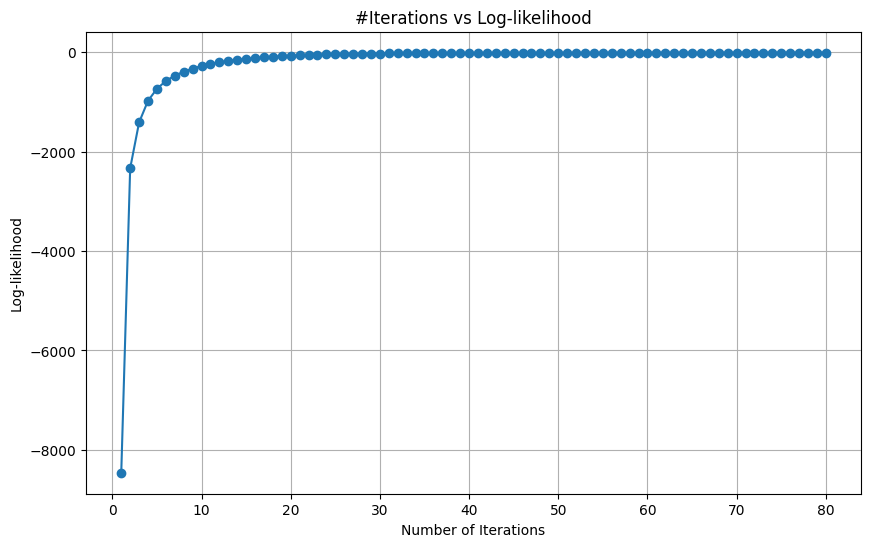

In [5]:
plot_itr_logl(pipe_g)

The following shows the training and the test misclassification error.

In [6]:
df = show_misclassification(pipe_g,
                            gisette_train_x,
                            gisette_train_y,
                            gisette_test_x,
                            gisette_test_y)
df

,Training Error,Test Error
0,0.0,0.021


The following shows the ROC curve of the model.

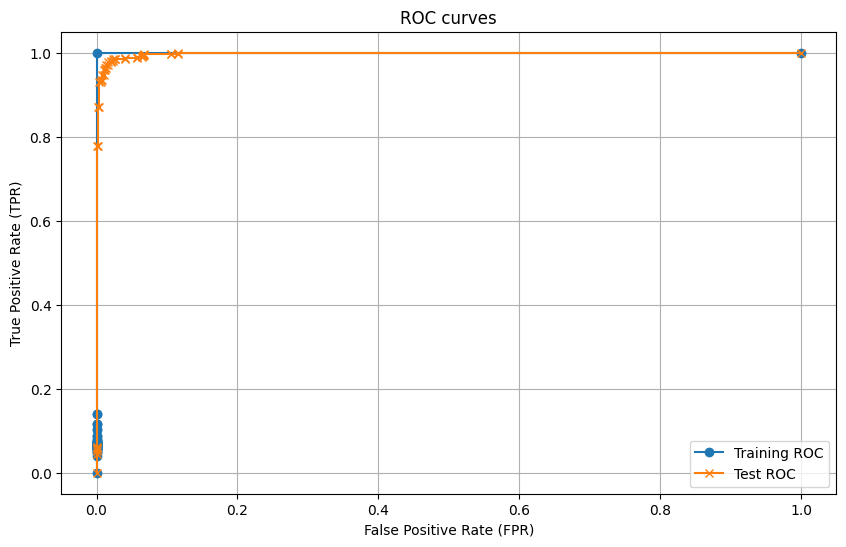

In [7]:
show_roc(pipe_g,
         gisette_train_x,
         gisette_train_y,
         gisette_test_x,
         gisette_test_y)

## Problem (b)
Repeat point a) on the hill-valley dataset, where you might need as many
as 10,000 iterations for it to converge. (2 points)

In [8]:
#Load hill-valley
path = "./hill-valley/"
train_x = dd.read_csv(os.path.join(path, 'X.dat'),
                         delim_whitespace = True,
                         header = None,
                         blocksize = None).compute()

train_y = dd.read_csv(os.path.join(path, 'Y.dat'),
                         delim_whitespace=True,
                         header = None,
                         blocksize = None).compute()

test_x = dd.read_csv(os.path.join(path, 'Xtest.dat'),
                         delim_whitespace=True,
                         header = None, 
                         blocksize = None).compute()

test_y = dd.read_csv(os.path.join(path, 'Ytest.dat'),
                         delim_whitespace=True,
                         header = None,
                         blocksize = None).compute()

# Replace -1 with 0 so that it fits the slides
train_y.replace(-1, 0, inplace = True)
test_y.replace(-1, 0, inplace = True)

In [9]:
pipe_h = Pipeline([('scaler', StandardScaler()), 
                     ('addbias', AddBias()),
                     ('logreg', LogisticRegressionGD(eta = 0.08,
                                                     eps = 2e-3,
                                                     max_iter = 10000))])

pipe_h.fit(train_x, train_y)

The number of iterations: 8989 , is_terminated_early: True
The maximal log-likelihood:  -362.5894765074911


Pipeline(steps=[('scaler', StandardScaler()),
                ('addbias', <__main__.AddBias object at 0x7fb1f11e9610>),
                ('logreg',
                 <__main__.LogisticRegressionGD object at 0x7fb1f11e9190>)])

The above shows that the learning rate of $0.08$ converges before the 10000th iteration. The following shows the plot between the number of iterations and the log-likelihood.

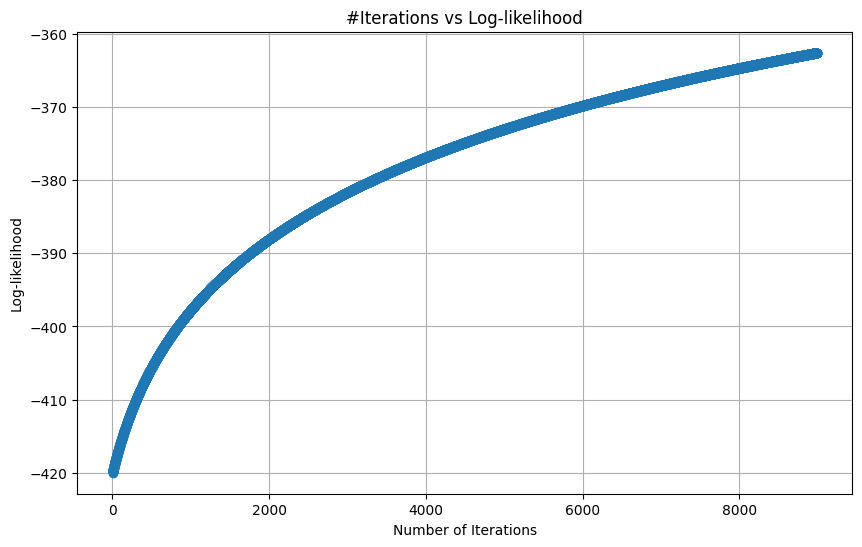

In [10]:
plot_itr_logl(pipe_h)

The following shows the training and the test misclassification errors.

In [11]:
show_misclassification(pipe_h, train_x, train_y, test_x, test_y)

,Training Error,Test Error
0,0.316832,0.334983


The following shows the ROC curve.

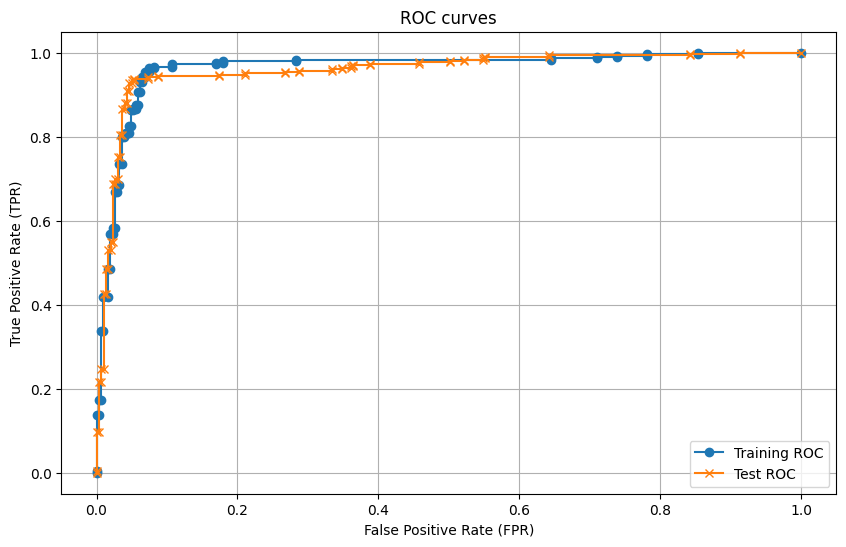

In [12]:
show_roc(pipe_h,
         train_x,
         train_y,
         test_x,
         test_y)

## Problem (c)
Repeat point a) on the dexter dataset.

In [13]:
#Load dexter
path = "./dexter/"

train_x = dd.read_csv(os.path.join(path, 'dexter_train.csv'),
                         header = None,
                         blocksize = None).compute()

train_y = dd.read_csv(os.path.join(path, 'dexter_train.labels'),
                         header = None,
                         blocksize = None).compute()

test_x = dd.read_csv(os.path.join(path, 'dexter_valid.csv'),
                         header = None,
                         blocksize = None).compute()

test_y = dd.read_csv(os.path.join(path, 'dexter_valid.labels'),
                         header = None,
                         blocksize = None).compute()

# Replace -1 with 0 so that it fits the slides
train_y.replace(-1, 0, inplace = True)
test_y.replace(-1, 0, inplace = True)

In [14]:
pipe_d = Pipeline([('scaler', StandardScaler()), 
                    ('addbias', AddBias()),
                     ('logreg', LogisticRegressionGD(eta = 1, eps = 1e-5, max_iter = 300))])
          
pipe_d.fit(train_x, train_y)

The number of iterations: 174 , is_terminated_early: True
The maximal log-likelihood:  -0.00416733323143805


Pipeline(steps=[('scaler', StandardScaler()),
                ('addbias', <__main__.AddBias object at 0x7fb1f0176eb0>),
                ('logreg',
                 <__main__.LogisticRegressionGD object at 0x7fb1f0176a00>)])

The above shows that the learning rate of $1$ converges before the 300th iteration. The following shows the plot between the number of iterations and the log-likelihood.

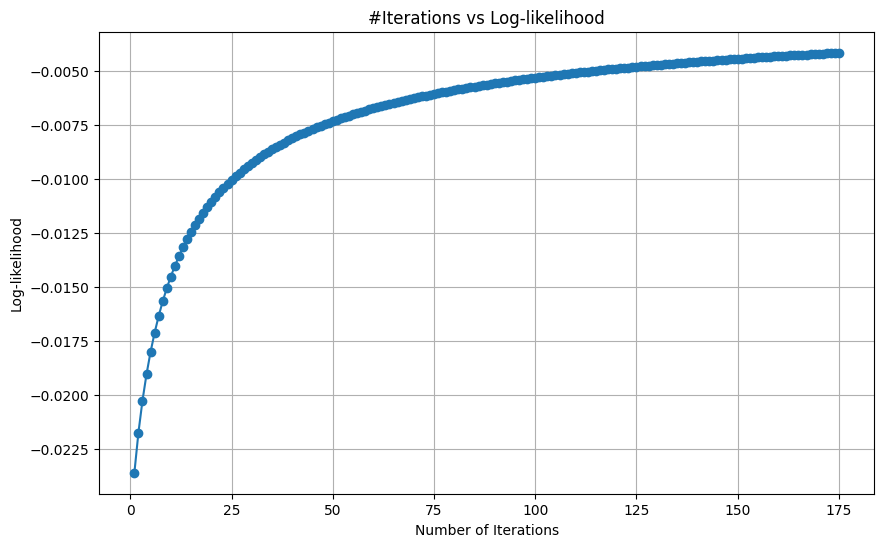

In [15]:
plot_itr_logl(pipe_d)

The following shows the training and the test misclassification error.

In [16]:
df = show_misclassification(pipe_d,
                            train_x,
                            train_y,
                            test_x,
                            test_y)
df

,Training Error,Test Error
0,0.0,0.156667


The following shows the ROC curve.

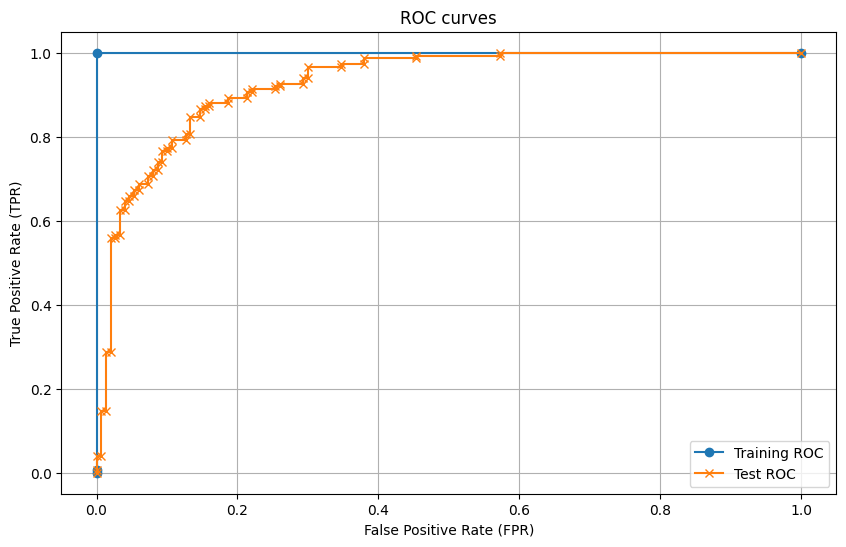

In [17]:
show_roc(pipe_d,
         train_x,
         train_y,
         test_x,
         test_y)

# Problem 2

For the Gisette data, minimize by gradient descent the L1-penalized logistic loss:
$C(w) = -\frac{1}{N}L(w) + \lambda\sum_{i=1}^{N}|w_i|$
by gradient descent starting from w(0) = 0, where λ = 0.01. Here L(w) is again the
log likelihood from page 7 of the Logistic Regression slides.
Find a good learning rate η such that the loss converges in at most 300 iterations
and is monotonically decreasing. Again, be sure to normalize the variables of the
1
training set to have zero mean and standard deviation 1, and to use the exact same
transformation on the test set, using the mean and standard deviation of the training
set.

In [18]:
class LogisticRegressionGD_L1():
    """ Logistic Regression using Gradient Descent.
    Args:
        eta (float) : Learning rate
        lamda (float) : Shrinking constant
        eps (float) : Convergence threshold
        max_iter (float) : # of maximum iterations
        w_ (numpy.array) : fitted coefficients
        losses (list) : loss function at each itr
        is_terminated_early (bool) : True if GD terminated early
        display (bool) : If true, outputs final log-likelihood and #itr
    """
    def __init__(self,
                 eta = 1,
                 lamda = 0.0001,
                 eps = 0.1,
                 max_iter = 300,
                 display = True):
        self.eta = eta
        self.lamda = lamda
        self.eps = eps
        self.max_iter = max_iter
        self.w_ = None
        self.losses = []
        self.is_terminated_early = False
        self.display = display
    
    def _grad(self, weights, X, y):
        """ Gradient of the negative log likelihood + grad(L1)
        """
        N = X.shape[0]
        wXT = np.matmul(weights, X.T)
        return -(1/N)*np.matmul(y-expit(wXT), X) \
                +self.lamda*np.sign(weights)
    
    def _loss(self, weights, X, y):
        """ negative log likelihood + L1 norm
        """
        N = X.shape[0]
        wXT = np.matmul(weights, X.T)
        y_new = np.where(wXT < 0, y, y-1)
        return -(1/N)*np.dot(y_new, wXT)+(1/N)*v_log_one_exp(wXT).sum() \
                +self.lamda*np.abs(weights).sum()

    def fit(self, X, y):
        self.w_ = np.zeros(X.shape[1])
        previous_loss = self._loss(self.w_, X, y.squeeze())
        # The gradient descent steps
        for i in range(self.max_iter):
            self.w_ = self.w_ - \
                self.eta*self._grad(self.w_, X, y.squeeze())
            loss_now = self._loss(self.w_, X, y.squeeze())
            self.losses.append(loss_now)
            if np.abs(previous_loss - loss_now) < self.eps:
                self.is_terminated_early = True
                break
            previous_loss = loss_now
        if display:
            print('The number of iterations:',
                    i,
                    ', is_terminated_early:',
                    self.is_terminated_early)
            print('The maximal log-likelihood: ', loss_now)

    def predict(self, X):
        wXT = np.matmul(self.w_, X.T)
        return np.where(expit(wXT)>0.5, 1, 0)
    
    def predict_proba(self, X):
        wXT = np.matmul(self.w_, X.T)
        return expit(wXT)
  

In [19]:
pipe_g = Pipeline([('scaler', StandardScaler()), 
                     ('addbias', AddBias()),
                     ('logreg', LogisticRegressionGD_L1(lamda=0.01,
                                                        eta = 5e-2,
                                                        eps = 1e-5))])

pipe_g.fit(gisette_train_x, gisette_train_y)

The number of iterations: 50 , is_terminated_early: True
The maximal log-likelihood:  0.2587619562691953


Pipeline(steps=[('scaler', StandardScaler()),
                ('addbias', <__main__.AddBias object at 0x7fb1f13d9df0>),
                ('logreg',
                 <__main__.LogisticRegressionGD_L1 object at 0x7fb1f13d9850>)])

The above shows that the learning rate of $eta = 0.05$ converges before the 300th iteration (with convergence threshold eps = 0.001).

## Problem (a)
 Plot the training loss vs iteration number. Report in a table the misclassification
error on the training and test set. (1 point

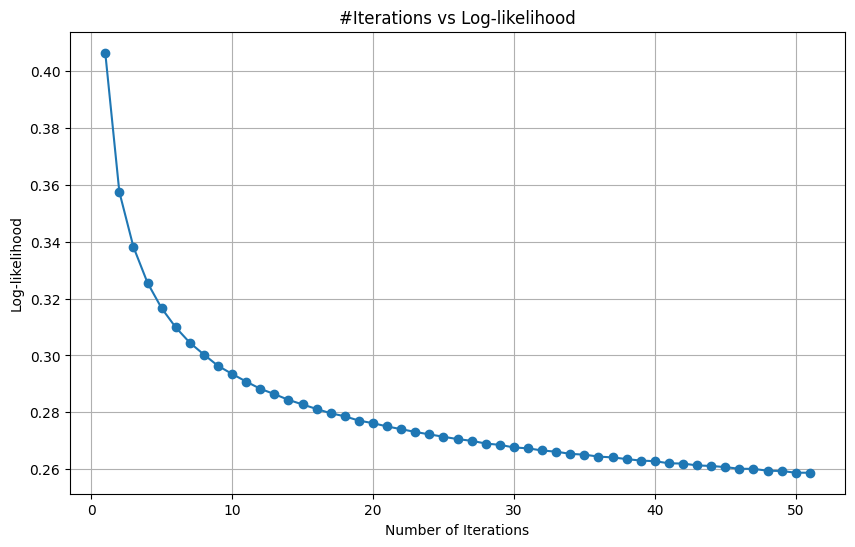

In [20]:
plot_itr_logl(pipe_g)

## Problem (b)

On the same graph, plot the Receiver Operating Characteristic (ROC) curve of
the obtained model on the training and test set. (1 point)

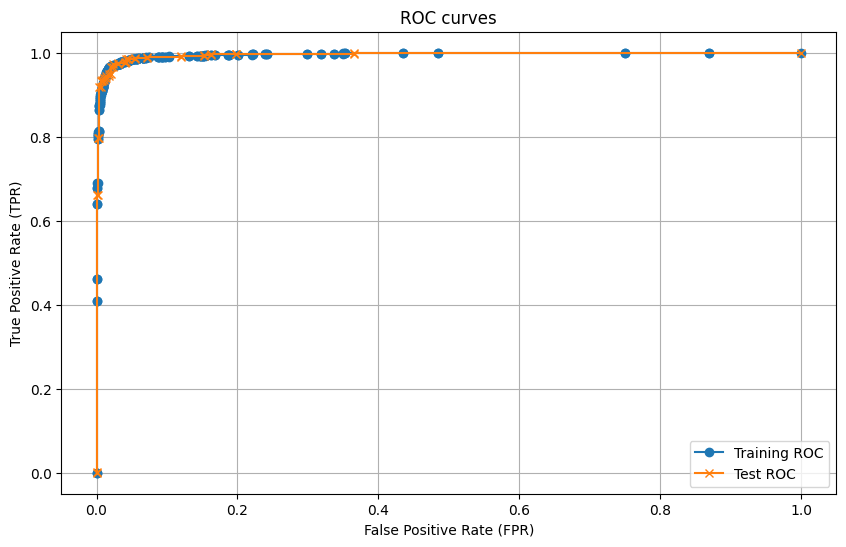

In [21]:
show_roc(pipe_g, gisette_train_x, gisette_train_y, gisette_test_x, gisette_test_y)

## Problem (c)
How many nonzero entries are in w? How many values in w satisfy |wi| > λ?

In [22]:
print('There are', np.count_nonzero(pipe_g['logreg'].w_),
       'elements with nonzero entries in w.')
print('There are', np.count_nonzero(np.abs(pipe_g['logreg'].w_) > pipe_g['logreg'].lamda),
      'elements with |w_i|>lambda.')

There are 4956 elements with nonzero entries in w.
There are 398 elements with |w_i|>lambda.
